# 1. Faster R-CNN

In [1]:
import sys
print(sys.version)

import torch
print(torch.__version__)

import torchvision
print(torchvision.__version__)

3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
2.2.2+cpu
0.17.2+cpu


In [2]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 2. Loading the Data


In [4]:
import os 

print('images', len(os.listdir('images')))
print('annotations', len(os.listdir('annotations')))
print('test_annotations', len(os.listdir('test_annotations')))
print('test_images', len(os.listdir('test_images')))

images 1580
annotations 1580
test_annotations 394
test_images 394


## 3. Data Separation


## 3.1. Defining the Dataset Class

In [5]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "Transverse Cracks":         return 0
    elif obj.find('name').text == "Longitudinal Cracks":     return 1
    elif obj.find('name').text == "Block Cracks":            return 2
    elif obj.find('name').text == "Alligator Cracks":        return 3
    elif obj.find('name').text == "Edge Cracks":             return 4
    elif obj.find('name').text == "Potholes":                return 5
    elif obj.find('name').text == "Rutting":                 return 6
    elif obj.find('name').text == "Raveling":                return 7
    elif obj.find('name').text == "Depression":              return 8
    elif obj.find('name').text == "Corrugation and shoving": return 9
    elif obj.find('name').text == "Patching":                return 10

def plot_image_from_output(img, annotation):
    # Convert the image tensor to a format suitable for plotting
    img = img.cpu().permute(1, 2, 0)
    
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Define a dictionary to map labels to edge colors
    label_to_color = {
        0: '#ff007c',
        1: '#018477',
        2: '#b4a808',
        3: '#ddff33',
        4: '#ff00cc',
        5: '#fa3253',
        6: '#24b353',
        7: '#bac99a',
        8: '#d3a298',
        9: '#505016',
        10: '#75c50d'
    }
    
    # Loop through the annotations and draw rectangles and labels
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        label = int(annotation['labels'][idx])
        edgecolor = label_to_color.get(label, 'r')  # Default to 'r' if label not in dictionary

        # Create and add the r ectangle
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)
        
        # Add the label text inside the rectangle
        text_x = xmin + (xmax - xmin) / 2
        text_y = ymin + (ymax - ymin) / 2
        ax.text(text_x, text_y, str(label), color='white', fontsize=8, ha='center', va='center', bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, boxstyle='round,pad=0.2'))
    
    # Display the plot
    plt.show()
    
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

## 3.2 Create the Dataset

In [6]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor(),
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

## 4. Import Model

In [7]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5. Train Model

In [10]:
model = get_model_instance_segmentation(12)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

c:\Users\caetano\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#Draw the model

In [11]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [58]:
print('----------------------train start--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

print('----------------------train end--------------------------')

----------------------train start--------------------------
epoch : 1, Loss : 121.46688079833984, time : 696.3792567253113
epoch : 2, Loss : 110.7833480834961, time : 662.5619494915009
epoch : 3, Loss : 102.07132720947266, time : 678.9357213973999
epoch : 4, Loss : 91.7964859008789, time : 684.6382827758789
epoch : 5, Loss : 82.36092376708984, time : 674.6949427127838
epoch : 6, Loss : 75.5700454711914, time : 670.3916652202606
epoch : 7, Loss : 68.86327362060547, time : 672.8874390125275
epoch : 8, Loss : 61.86488342285156, time : 660.6624176502228
epoch : 9, Loss : 58.15755081176758, time : 679.4334750175476
epoch : 10, Loss : 53.533329010009766, time : 670.6476686000824
----------------------train end--------------------------


In [59]:
torch.save(model.state_dict(),f'model_tcc1_{num_epochs}.pt')

In [14]:
model.load_state_dict(torch.load(f'model_tcc1_{num_epochs}.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

## 6. Inference


In [15]:
def make_prediction(modeln, img, threshold):
    model.eval()
    preds = model(img)

    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [16]:
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        break

In [19]:
with torch.no_grad(): 
    for index, (imgs, annotations) in enumerate(test_data_loader):
        if index == 0:
            img_at_position = list(img.to(device) for img in imgs)
            pred = make_prediction(model, img_at_position, 0.1)
            #print(pred)
            break

In [20]:
# Function to remove scores from a tensor dictionary
def remove_scores(tensor_dict):
    # Create a new dictionary without the 'scores' key
    new_dict = {key: value for key, value in tensor_dict.items() if key != 'scores'}
    return new_dict

def remove_device(tensor_dict):
    new_dict = {}
    for key, value in tensor_dict.items():
        # Move the tensor to CPU memory
        new_dict[key] = value.to('cpu')
    return new_dict

def remove_cuda(tensor_dict):
    new_dict = {}
    for key, value in tensor_dict.items():
        # Move the tensor to CPU memory
        new_dict[key] = value.to('cpu').detach().numpy()
    return new_dict


Target :  tensor([6])


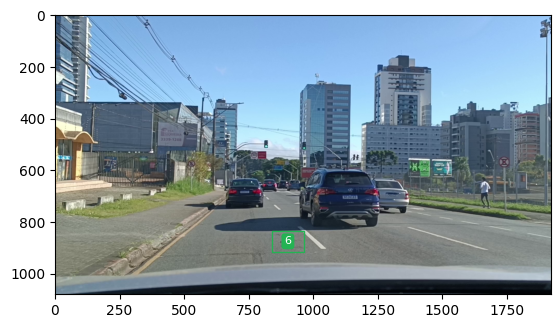

Prediction :  tensor([3, 5, 2])


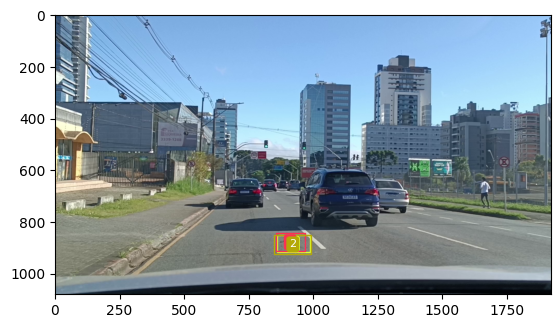

In [27]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])

newpred1 = remove_scores(pred[_idx])
newpred2 = remove_device(newpred1)
newpred3 = remove_cuda(newpred2)

print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], newpred3)

## 7. Prediction

In [28]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.1)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 99/99 [07:59<00:00,  4.84s/it]


In [29]:
%cd utils/
import utils as utils
%cd ..

d:\python\tcc1\utils
d:\python\tcc1


C:\Users\caetano\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [30]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.1) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.18035289728361015
AP : tensor([0.0000, 0.5370, 0.1818, 0.2623, 0.0000, 0.2625, 0.0000, 0.1061, 0.0000,
        0.0000, 0.6341], dtype=torch.float64)


In [31]:
# Extract labels
all_labels = set()
for sublist in annot_all:
    for dictionary in sublist:
        labels = dictionary['labels']
        all_labels.update(labels.tolist())

print("All labels:", all_labels)

All labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [117]:
annot_all

[({'boxes': tensor([[ 595.1700,  843.2600,  735.3400, 1005.4800]]),
   'labels': tensor([9])},
  {'boxes': tensor([[838.8100, 834.2800, 964.6500, 914.8100]]),
   'labels': tensor([6])},
  {'boxes': tensor([[1288.2500,  880.9700, 1635.0000,  974.5800]]),
   'labels': tensor([8])},
  {'boxes': tensor([[479.9200, 817.9300, 575.6900, 933.2900]]),
   'labels': tensor([1])}),
 ({'boxes': tensor([[1649.9700,  871.0200, 1889.0601,  968.3400]]),
   'labels': tensor([1])},
  {'boxes': tensor([[1288.3900,  870.1800, 1451.9800,  953.2400]]),
   'labels': tensor([10])},
  {'boxes': tensor([[ 891.3700,  815.6500, 1029.4500,  927.7200],
           [1125.6400,  787.9700, 1686.2800,  961.3000]]),
   'labels': tensor([ 1, 10])},
  {'boxes': tensor([[612.6200, 908.3400, 881.9600, 964.6800]]),
   'labels': tensor([10])}),
 ({'boxes': tensor([[ 867.2300,  731.3900, 1044.4100,  793.0200],
           [ 336.9700,  818.7000,  817.2800,  966.3500]]),
   'labels': tensor([10, 10])},
  {'boxes': tensor([[ 256.080

In [118]:
preds_adj_all

[[{'boxes': tensor([[443.4905, 801.6332, 778.3640, 939.7613],
           [470.4261, 785.4505, 926.5794, 966.5278],
           [671.2195, 801.9413, 985.9363, 985.4163]]),
   'labels': tensor([10, 10, 10]),
   'scores': tensor([0.8101, 0.3736, 0.1426])},
  {'boxes': tensor([[861.0060, 850.4546, 986.0511, 917.0008],
           [854.1541, 842.0814, 967.0040, 913.4958],
           [849.7410, 850.1036, 991.6933, 922.0767]]),
   'labels': tensor([3, 5, 2]),
   'scores': tensor([0.4367, 0.2467, 0.2261])},
  {'boxes': tensor([[ 581.1387,  779.0114, 1129.4055,  934.1393]]),
   'labels': tensor([10]),
   'scores': tensor([0.1443])},
  {'boxes': tensor([[ 792.6920,  826.5624, 1115.4861,  929.3514]]),
   'labels': tensor([10]),
   'scores': tensor([0.1479])}],
 [{'boxes': tensor([[1639.8711,  871.9645, 1855.1042,  964.6418],
           [1648.3850,  875.1622, 1727.2799,  924.2620],
           [1647.7211,  864.1683, 1858.1230,  964.2228],
           [1648.8367,  873.3611, 1777.3259,  937.9738]]),
   

In [32]:
precision

tensor([0.0000, 0.5000, 0.1818, 0.2190, 0.0000, 0.1373, 0.0000, 0.2157, 0.0000,
        0.0000, 0.3694], dtype=torch.float64)

In [33]:
recall

tensor([0.0000, 0.6505, 0.3636, 0.4792, 0.0000, 0.4375, 0.0000, 0.1930, 0.0000,
        0.0000, 0.8483], dtype=torch.float64)

In [34]:
AP

tensor([0.0000, 0.5370, 0.1818, 0.2623, 0.0000, 0.2625, 0.0000, 0.1061, 0.0000,
        0.0000, 0.6341], dtype=torch.float64)

In [35]:
f1

tensor([0.0000, 0.5654, 0.2424, 0.3007, 0.0000, 0.2090, 0.0000, 0.2037, 0.0000,
        0.0000, 0.5146], dtype=torch.float64)

In [36]:
# Extract types tensors
all_labels = set()
for sublist in preds_adj_all:
    for dictionary in sublist:
        labels = dictionary['labels']
        all_labels.update(labels.tolist())

print("All labels:", all_labels)

All labels: {1, 2, 3, 5, 7, 9, 10}


In [37]:
# Extract scores tensors and calculate the average
total_scores = []
for sublist in preds_adj_all:
    for dictionary in sublist:
        total_scores.append(dictionary['scores'])

all_scores = torch.cat(total_scores)
average_score = torch.mean(all_scores)

print("Average score:", average_score.item())

Average score: 0.46806055307388306


In [38]:
import pandas as pd
import torch

In [41]:
# Dados fornecidos
labels = ['Transverse Cracks', 'Longitudinal Cracks', 'Block Cracks', 'Alligator Cracks', 'Edge Cracks', 'Potholes', 'Rutting', 'Raveling', 'Depression', 'Corrugation and shoving', 'Patching']

# Criação do DataFrame
data = {
    'Label': labels,
    'Precision': precision.numpy(),
    'Recall': recall.numpy(),
    'F1 Score': f1.numpy(),
    'AP': AP.numpy()    
}

df = pd.DataFrame(data)

# Exibir o DataFrame
print(df)

                      Label  Precision    Recall  F1 Score        AP
0         Transverse Cracks   0.000000  0.000000  0.000000  0.000000
1       Longitudinal Cracks   0.500000  0.650485  0.565401  0.537001
2              Block Cracks   0.181818  0.363636  0.242424  0.181818
3          Alligator Cracks   0.219048  0.479167  0.300654  0.262323
4               Edge Cracks   0.000000  0.000000  0.000000  0.000000
5                  Potholes   0.137255  0.437500  0.208955  0.262505
6                   Rutting   0.000000  0.000000  0.000000  0.000000
7                  Raveling   0.215686  0.192982  0.203704  0.106088
8                Depression   0.000000  0.000000  0.000000  0.000000
9   Corrugation and shoving   0.000000  0.000000  0.000000  0.000000
10                 Patching   0.369369  0.848276  0.514644  0.634146


In [42]:
# Salvar o DataFrame no formato CSV
csv_file_path = 'output.csv'
df.to_csv(csv_file_path, index=False)

print(f"DataFrame salvo como {csv_file_path}")

DataFrame salvo como output.csv
